# Symbolic Regression with Genetic Programming

Import algorithms and selectors from modules in `core`; import representation-related operators from the appropriate  module in `evolvables` (in this case, `evolvables.gp` for tree-based genetic programming).

The following modules are imported:

- `SimpleLinearAlgorithm` for a simple algorithm that applies the variator, the evaluator, and the selector in this exact order.

- `Population` contains individuals used in the learning process.

- `Elitist` and `TournamentSelector` together construct an elitist tournament selector.

- `Program` represents a tree-based genetic program, `ProgramFactory` constructs instances of `Program`.

- `SymbolicEvaluator` evaluates instances of `Program`.

- `CrossoverSubtree` creates new `Program`s from existing ones.

In [2]:
from evokit.core.algorithm import SimpleLinearAlgorithm
from evokit.core.population import Population
from evokit.core.selector import Elitist, SimpleSelector, TournamentSelector

from evokit.evolvables.funcs import *
from evokit.evolvables.gp import CrossoverSubtree, ProgramFactory, Program, SymbolicEvaluator

from typing import Tuple

To begin, initialise the following hyperparameters:

- `POP_SIZE` is the size of the population. It affects the size of the initial population, and affects how many individuals are selected by the selector.

- `STEP_COUNT` decides the number of generation before termination.

- `TREE_DEPTH` and `NODE_BUDGET` affect how the `ProgramFactory` builds programs. By default, the factory builds with a modified full method, where it can only draw terminal nodes when depth exceeds `TREE_DEPTH` and the total number of nodes exceeds `NODE_BUDGET`.

In [3]:
POP_SIZE = 50
STEP_COUNT = 50

TREE_DEPTH = 4
NODE_BUDGET = 20

Define a program factory with a set of primitives and the arity of programs produced. Here, arity=1 means produced programs are unary.

In [4]:
progf: ProgramFactory[float] =\
        ProgramFactory((add, sub, mul, div, sin, cos, mul, div, 2, 1, 0.5),
        arity = 1)

Define, then populate a population. The optional parameter `nullary_ratio` forces the factory to select terminal nodes with that probability; therefore, a higher value encourages wider trees. This setting does not bypass `TREE_DEPTH` and `NODE_BUDGET`.

In [5]:
pops: Population[Program[float]] = Population()

for i in range(0, POP_SIZE):
    new_individual: Program[float] = progf.build(NODE_BUDGET, TREE_DEPTH, nullary_ratio=0.25)
    pops.append(new_individual)

Define an objective function, then initialise an symbolic evaluator using that objective function. The parameter `support` decides the domain on which each program is compared against the objective function.

Note that `SymbolicEvaluator` is genetic. Whereas the type of `new_individual` is Program[float], the type `SymbolicEvaluator` needs no subscript. This is because this evaluator is defined only for programs of floating-point numbers.

In [6]:
def weird_function(x):
    return sin(x)+2*cos(x)

support: Tuple[Tuple[float], ...] = tuple((x/4,) for x in range(-80, 80))

symbolic_fitness: SymbolicEvaluator = SymbolicEvaluator(objective=weird_function, support = support)

Pick the selectors and the variator, then initialise the algorithm using the operators defined so far.

The interceptor `Elitist` forces its argument, which must be a selector, to adopt elitism.

The `CrossoverSubtree` uses two parents. It randomly selects one internal node from each parent, selects one child node for each internal node, then exchanges the selected child nodes.

In [7]:
tournament_selector = Elitist(TournamentSelector(POP_SIZE))

crossover_subtree = CrossoverSubtree()

ctrl = SimpleLinearAlgorithm(evaluator=symbolic_fitness,
                              selector=tournament_selector,
                              population=pops,
                              variator=crossover_subtree)

In [8]:
bests = []

for _ in range(STEP_COUNT):
    ctrl.step()
    generational_best = ctrl.population.best()
    bests.append(generational_best.copy())

    print(f"Generation: {ctrl.generation}")
    print(f"Best individual is: {generational_best}, with fitnss {generational_best.fitness}")

Generation: 1
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 2
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 3
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 4
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 5
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 6
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 7
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 8
Best individual is: Program:sin(add(mul(1, div(1, 1)), x0)), with fitnss -127.65582808704299
Generation: 9
Best individual is: Program:mul(1, cos(sub(0.5, x0))), with fitnss -126.51070812473542
Generation: 10
Best individual is: Program:

Note that the fitness of the best individual never declines - this is because the interceptor `Elitist` successfully turns the tournament selector elitist. This is expected behaviour.

Each `Program.genome` is a callable function - as an example, call the best individual of the last generation with argument 1.

In [9]:
bests[0].genome(1)

0.9092974268256817

The module `evokit.evolvables.gp_visualiser` contains an utility for visualising genetic programs. Use it to visualise the last best individual. Because the tournament selector is elitist, this individual is also the best in all generations.

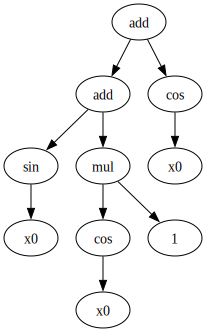

In [10]:
from evokit.evolvables.gp_visualiser import p2dot
p2dot(bests[-1])

To visualise the learning process: note that earlier highest-fitness programs (whose plotted colours are lighter) do not approximate the objective function as closely as later ones.

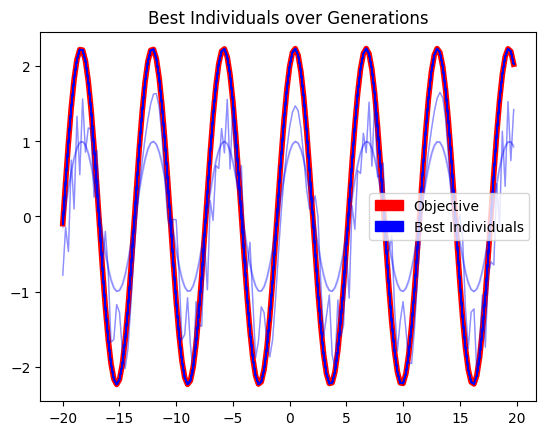

In [28]:
from typing import Sequence
from typing import Tuple
from typing import Callable

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

def plot_range(function: Callable[[float], float],
               support:Sequence[Tuple[float,]],
               color: str,
               alpha: float,
               linewidth: float):
    xs = [t[0] for t in support]
    ys = [function(x) for x in xs]
    plt.plot(xs, ys, color=color, alpha=alpha, linewidth=linewidth)

def alpha_from_index(bests, index):
    return index / len(bests) / 2

plot_range(weird_function, support, "red", 1, 4)

for i in range(len(bests)):
    plot_range(bests[i].genome, support, "blue", alpha_from_index(bests, i), 1)

plt.title('Best Individuals over Generations')


obj_color = Patch(color='red', label='Objective')
bests_color = Patch(color='blue', label='Best Individuals')
plt.legend(handles=[obj_color, bests_color])


plt.show()

The following plot illustrates the learning curve.

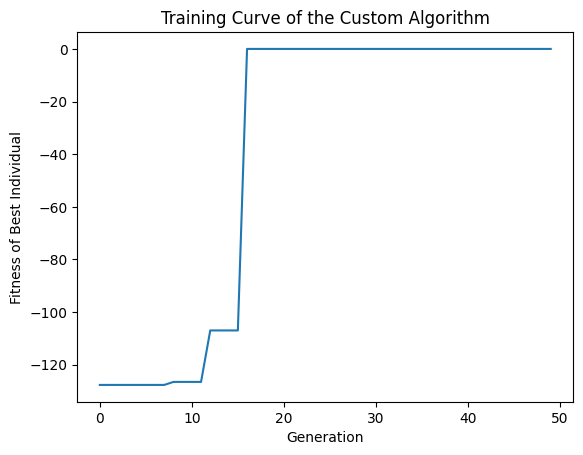

In [27]:
plt.plot(list(range(len(bests))), [ind.fitness for ind in bests])
plt.title('Training Curve of the Custom Algorithm')
plt.xlabel('Generation')
plt.ylabel('Fitness of Best Individual')
plt.show()